### Case Study (Reccommendation engine - Movies) #####

In [4]:
# Getting the Data
data = read.table('u.data')

In [5]:
# renaming column names
colnames(data) = c("user_id", "item_id", "rating", "timestamp")
# deleting the last column contain timestamps
data = data[-4]
# check the data
str(data)

'data.frame':	100000 obs. of  3 variables:
 $ user_id: int  196 186 22 244 166 298 115 253 305 6 ...
 $ item_id: int  242 302 377 51 346 474 265 465 451 86 ...
 $ rating : int  3 3 1 2 1 4 2 5 3 3 ...


In [6]:
# key summary for each column
summary(data)

    user_id         item_id           rating    
 Min.   :  1.0   Min.   :   1.0   Min.   :1.00  
 1st Qu.:254.0   1st Qu.: 175.0   1st Qu.:3.00  
 Median :447.0   Median : 322.0   Median :4.00  
 Mean   :462.5   Mean   : 425.5   Mean   :3.53  
 3rd Qu.:682.0   3rd Qu.: 631.0   3rd Qu.:4.00  
 Max.   :943.0   Max.   :1682.0   Max.   :5.00  

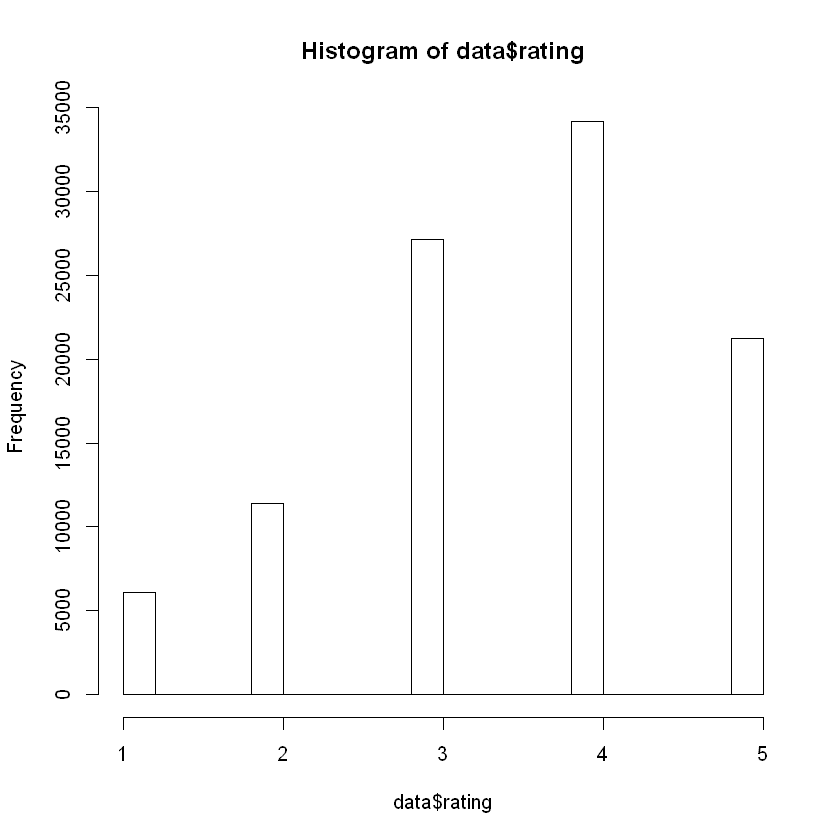

In [7]:
# plotting histogram from ratings
hist(data$rating)

In [8]:
# The data sparsity can be calculated as follow
#Sparsity = (# of ratings / # of movies * # of Users) * 100% """

# No. of Ratings
num_ratings = nrow(data)
# No. of Movies
num_movies = length(unique(data$item_id))
# No. of Users
num_users = length(unique(data$user_id))
# Compute the Sparsity
sparsity = num_ratings / (num_movies * num_users) * 100
print(c('Sparsity of Dataset is', sparsity))

[1] "Sparsity of Dataset is" "6.30466936422453"      


In [9]:
# subset data that users with 50 or more ratings remain
data = data[ data$user_id %in% 
               names(table(data$user_id))[table(data$user_id) > 50] , ]

In [10]:
# Now, we can recalculate the sparsity as we did earlier.
num_ratings = nrow(data)
num_movies = length(unique(data$item_id))
num_users = length(unique(data$user_id))
sparsity = num_ratings / (num_movies * num_users) * 100
print(c('UPDATED Sparsity of Dataset is', sparsity))

[1] "UPDATED Sparsity of Dataset is" "9.32171601315719"              


In [12]:
# convert our data to a graphlab SFrame object

library('recommenderlab')
# First, we convert our data type to a recommenderlab compatible type
data_new = as(data, "realRatingMatrix")
# Now, we apply a split of 0.7 train, 0.3 test
# Need to tell recommender lab what the top rating is (5)
data_split = evaluationScheme(data_new, method="split", train=0.7, given=15, goodRating=5)
train = getData(data_split, "train")
test_X = getData(data_split, "known")
test_Y = getData(data_split, "unknown")

In [13]:
####   Integrating a Popularity Recommender ####
rec_pop = Recommender(train, method="POPULAR")

In [14]:
####   Integrating a Popularity Recommender ####
rec_pop = Recommender(train, method="POPULAR")

In [15]:
# Test set Evaluation
predicted = predict(rec_pop, test_X, type="ratings")
error = calcPredictionAccuracy(predicted, test_Y)
error

RMSE       MSE       MAE 
0.9617548 0.9249724 0.7621673

In [16]:
##### Integrating a Collaborative Filtering Recommender ######

val_split = evaluationScheme(train, method="split", train=0.7, given=15, goodRating=5)
train_real = getData(val_split, "train")
val_X = getData(val_split, "known")
val_Y = getData(val_split, "unknown")

In [17]:

##### Integrating a Collaborative Filtering Recommender ######

val_split = evaluationScheme(train, method="split", train=0.7, given=15, goodRating=5)
train_real = getData(val_split, "train")
val_X = getData(val_split, "known")
val_Y = getData(val_split, "unknown")


In [18]:
# performance comparison train data and its application on validation set

# Create model
rec_ubcf = Recommender(train_real, "UBCF")
predicted_ubcf = predict(rec_ubcf, val_X, type="ratings")
# Now, we compute the RMSE
error_ubcf = calcPredictionAccuracy(predicted_ubcf, val_Y)
print(error_ubcf)

     RMSE       MSE       MAE 
1.0710054 1.1470526 0.8529116 


In [20]:
##### Integrating an Item-Item Similarity Recommender #####
# Create model
rec_ibcf = Recommender(train, "IBCF")
predicted_ibcf = predict(rec_ibcf, test_X, type="ratings")
# Now, we compute the RMSE
error_ibcf = calcPredictionAccuracy(predicted_ibcf, test_Y)
print(error_ibcf)

     RMSE       MSE       MAE 
1.2945936 1.6759726 0.9164568 


In [21]:
########### Getting Top k Recommendations ###############

results_pop <- evaluate(data_split, method="POPULAR", type="topNList", n=c(5, 10))
results_ubcf <- evaluate(data_split, method="UBCF", type="topNList", n=c(5, 10))
results_ibcf <- evaluate(data_split, method="IBCF", type="topNList", n=c(5, 10))

POPULAR run fold/sample [model time/prediction time]
	 1  [0.03sec/2.1sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.13sec/3sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [72.81sec/0.31sec] 


In [22]:
##########  Evaluation: Confusion Matrix, Precision and Recall ######

print(c('Popularity', results_pop@results))

print(c('Collaborative Filtering', results_ubcf@results))

print(c('Item-Item Similarity', results_ibcf@results))

[[1]]
[1] "Popularity"

[[2]]
An object of class "confusionMatrix"
Slot "cm":
         TP       FP       FN       TN precision     recall        TPR
5  1.544379 3.455621 24.57396 1636.426 0.3088757 0.08093168 0.08093168
10 2.816568 7.183432 23.30178 1632.698 0.2816568 0.13366614 0.13366614
           FPR
5  0.002101132
10 0.004368201

Slot "model":
NULL


[[1]]
[1] "Collaborative Filtering"

[[2]]
An object of class "confusionMatrix"
Slot "cm":
         TP       FP       FN       TN precision     recall        TPR
5  0.887574 4.112426 25.23077 1635.769 0.1775148 0.03912622 0.03912622
10 1.431953 8.568047 24.68639 1631.314 0.1431953 0.06512031 0.06512031
           FPR
5  0.002502869
10 0.005216320

Slot "model":
NULL


[[1]]
[1] "Item-Item Similarity"

[[2]]
An object of class "confusionMatrix"
Slot "cm":
           TP       FP       FN       TN   precision       recall          TPR
5  0.01183432 4.988166 26.10651 1634.893 0.002366864 0.0003226071 0.0003226071
10 0.02366864 9.976331 26